In [1]:
pip install segment-anything-py

Note: you may need to restart the kernel to use updated packages.


In [2]:
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

--2025-05-13 09:56:00--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 108.158.20.43, 108.158.20.21, 108.158.20.111, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|108.158.20.43|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth.1’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   255MB/s    in 8.6s    

2025-05-13 09:56:08 (284 MB/s) - ‘sam_vit_h_4b8939.pth.1’ saved [2564550879/2564550879]



In [3]:
pip install rasterio

Note: you may need to restart the kernel to use updated packages.


In [4]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import cv2
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
import json
from PIL import Image
import os
import torch
import torch.nn as nn
import torch.nn.functional as F

In [5]:
dataset_path_tmn = "/kaggle/input/tman-mini-rgnan-geotiff/geotiff-tmn-rgn/Taman Mini"
number_to_load_tmn = ['417712', '417713', '417714', '417715', '417716', '417717', '417718', '417719']

dataset_path_rgn = "/kaggle/input/tman-mini-rgnan-geotiff/geotiff-tmn-rgn/Ragunan-data"
number_to_load_rgn = ['208840', '208841', '208842', '208843']

images_paths = []
masks_paths = []

for numb_name in number_to_load_tmn:
    images_dir = os.path.join(dataset_path_tmn, 'image', numb_name)
    masks_dir = os.path.join(dataset_path_tmn, 'mask', numb_name)
    if os.path.isdir(images_dir) and os.path.isdir(masks_dir):
        image_path = sorted([os.path.join(images_dir, f) for f in os.listdir(images_dir) if f.endswith('.tif')])
        mask_path = sorted([os.path.join(masks_dir, f) for f in os.listdir(masks_dir) if f.endswith('.tif')])
        
        images_paths.extend(image_path)
        masks_paths.extend(mask_path)

for numb_name in number_to_load_rgn:
    images_dir = os.path.join(dataset_path_rgn, 'image', numb_name)
    masks_dir = os.path.join(dataset_path_rgn, 'mask', numb_name)
    if os.path.isdir(images_dir) and os.path.isdir(masks_dir):
        image_path = sorted([os.path.join(images_dir, f) for f in os.listdir(images_dir) if f.endswith('.tif')])
        mask_path = sorted([os.path.join(masks_dir, f) for f in os.listdir(masks_dir) if f.endswith('.tif')])
        
        images_paths.extend(image_path)
        masks_paths.extend(mask_path)

In [6]:
from sklearn.model_selection import train_test_split

image_train, image_test, mask_train, mask_test = train_test_split(
    images_paths, masks_paths, test_size = 0.2, random_state = 42 
)

image_test, image_val, mask_test, mask_val = train_test_split(
    image_test, mask_test, test_size = 0.5, random_state = 42 
)

In [7]:
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose([
    A.HorizontalFlip(p = 0.5),
    A.RandomBrightnessContrast(p = 0.2),
    ToTensorV2()
])

test_transform = A.Compose([ 
    ToTensorV2()
])

class SegmentDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform = None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform 

    def __len__(self):
        return len(self.image_paths)

    def normalize(self, image, mask):
        image = (image - image.min()) / (image.max() - image.min() + 1e-8) 
        mask = (mask > 0.5).float()  
        return image, mask
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        image = np.array(Image.open(image_path).convert("RGB"), dtype = np.float32)
        mask = np.array(Image.open(mask_path).convert("L"), dtype = np.uint8) 

        if self.transform:    
            augmented = self.transform(image = image, mask = mask)
            image = augmented["image"]
            mask = augmented["mask"]
        else:
            image = torch.tensor(image).permute(2, 0, 1) / 255.0
            mask = torch.tensor(mask)
        
        mask = (mask > 0.5).float()
        mask = mask.unsqueeze(0).float()

        image, mask = self.normalize(image, mask)

        return image, mask, image_path, mask_path

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [8]:
train_dataset = SegmentDataset(image_train, mask_train, transform = train_transform)
train_loader = DataLoader(train_dataset, batch_size = 1, num_workers = 0, pin_memory = False, shuffle = True)

test_dataset = SegmentDataset(image_test, mask_test, transform = test_transform)
test_loader = DataLoader(test_dataset, batch_size = 1, num_workers = 0, pin_memory = False, shuffle = False)

val_dataset = SegmentDataset(image_val, mask_val, transform = test_transform)
val_loader = DataLoader(val_dataset, batch_size = 1, num_workers = 0, pin_memory = False, shuffle = False)

In [9]:
img_tr, mask_tr, img_path, mask_path = train_dataset[0]
print(img_tr)
print(img_tr.shape)

tensor([[[0.4431, 0.3882, 0.3725,  ..., 0.1804, 0.3647, 0.2353],
         [0.4314, 0.4157, 0.3804,  ..., 0.3333, 0.3216, 0.3569],
         [0.4039, 0.4196, 0.3765,  ..., 0.2706, 0.2745, 0.2588],
         ...,
         [0.1843, 0.2392, 0.2078,  ..., 0.3490, 0.4196, 0.4235],
         [0.0706, 0.2706, 0.2392,  ..., 0.3843, 0.3608, 0.3961],
         [0.1569, 0.1882, 0.0510,  ..., 0.0667, 0.1569, 0.2118]],

        [[0.4235, 0.3686, 0.3686,  ..., 0.2510, 0.4314, 0.3020],
         [0.4196, 0.4039, 0.3765,  ..., 0.4039, 0.3882, 0.4235],
         [0.4000, 0.4235, 0.3882,  ..., 0.3412, 0.3412, 0.3255],
         ...,
         [0.2275, 0.2784, 0.2510,  ..., 0.5020, 0.5569, 0.5490],
         [0.1098, 0.3098, 0.2784,  ..., 0.5490, 0.5137, 0.5373],
         [0.1961, 0.2235, 0.0902,  ..., 0.2392, 0.3137, 0.3647]],

        [[0.3490, 0.2941, 0.2980,  ..., 0.1647, 0.3569, 0.2275],
         [0.3451, 0.3373, 0.3059,  ..., 0.3176, 0.3137, 0.3490],
         [0.3294, 0.3529, 0.3137,  ..., 0.2549, 0.2667, 0.

In [10]:
print(mask_tr)
print(mask_tr.shape)

tensor([[[0., 0., 0.,  ..., 1., 1., 1.],
         [0., 0., 0.,  ..., 1., 1., 1.],
         [0., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 0., 1.,  ..., 0., 0., 1.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [1., 1., 0.,  ..., 0., 0., 0.]]])
torch.Size([1, 256, 256])


In [11]:
img_te, mask_te, img_path, mask_path = test_dataset[0]
print(img_te)
print(img_te.shape)

tensor([[[0.4784, 0.4471, 0.4863,  ..., 0.4980, 0.6431, 0.5412],
         [0.4863, 0.4549, 0.4745,  ..., 0.8627, 0.8549, 0.4941],
         [0.4941, 0.4784, 0.4980,  ..., 0.8353, 0.8196, 0.5020],
         ...,
         [0.7176, 0.7059, 0.6510,  ..., 0.5255, 0.7098, 0.7804],
         [0.7137, 0.7647, 0.7137,  ..., 0.5451, 0.6667, 0.6588],
         [0.7608, 0.7647, 0.7412,  ..., 0.5843, 0.6039, 0.7373]],

        [[0.5294, 0.4980, 0.5333,  ..., 0.5373, 0.6627, 0.5647],
         [0.5333, 0.5020, 0.5216,  ..., 0.8902, 0.8745, 0.5176],
         [0.5333, 0.5176, 0.5373,  ..., 0.8627, 0.8392, 0.5137],
         ...,
         [0.5961, 0.5961, 0.5529,  ..., 0.4431, 0.6392, 0.7176],
         [0.5529, 0.6157, 0.5882,  ..., 0.4588, 0.5843, 0.5882],
         [0.5804, 0.6000, 0.5922,  ..., 0.4980, 0.5176, 0.6588]],

        [[0.4902, 0.4588, 0.4941,  ..., 0.5020, 0.6353, 0.5255],
         [0.4941, 0.4627, 0.4824,  ..., 0.8588, 0.8471, 0.4784],
         [0.4902, 0.4745, 0.4941,  ..., 0.8314, 0.8118, 0.

In [12]:
print(mask_te)
print(mask_te.shape)

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
torch.Size([1, 256, 256])


In [13]:
for i, (image, mask, img_path, mask_path) in enumerate(train_dataset):
    if mask.sum() == 0:
        print(f"Empty mask at {i}")

Empty mask at 21


In [14]:
for i, (image, mask, img_path, mask_path) in enumerate(test_dataset):
    if mask.sum() == 0:
        print(f"Empty mask at {i}")

In [15]:
for i, (image, mask, img_path, mask_path) in enumerate(val_dataset):
    if mask.sum() == 0:
        print(f"Empty mask at {i}")

In [16]:
for img, msk, img_path, mask_path in train_loader:
    print("image shape:", img.shape) 
    print("mask shape:", msk.shape)

image shape: torch.Size([1, 3, 256, 256])
mask shape: torch.Size([1, 1, 256, 256])
image shape: torch.Size([1, 3, 256, 256])
mask shape: torch.Size([1, 1, 256, 256])
image shape: torch.Size([1, 3, 256, 256])
mask shape: torch.Size([1, 1, 256, 256])
image shape: torch.Size([1, 3, 256, 256])
mask shape: torch.Size([1, 1, 256, 256])
image shape: torch.Size([1, 3, 256, 256])
mask shape: torch.Size([1, 1, 256, 256])
image shape: torch.Size([1, 3, 256, 256])
mask shape: torch.Size([1, 1, 256, 256])
image shape: torch.Size([1, 3, 256, 256])
mask shape: torch.Size([1, 1, 256, 256])
image shape: torch.Size([1, 3, 256, 256])
mask shape: torch.Size([1, 1, 256, 256])
image shape: torch.Size([1, 3, 256, 256])
mask shape: torch.Size([1, 1, 256, 256])
image shape: torch.Size([1, 3, 256, 256])
mask shape: torch.Size([1, 1, 256, 256])
image shape: torch.Size([1, 3, 256, 256])
mask shape: torch.Size([1, 1, 256, 256])
image shape: torch.Size([1, 3, 256, 256])
mask shape: torch.Size([1, 1, 256, 256])
imag

In [17]:
for img, msk, img_path, mask_path in test_loader:
    print("image shape:", img.shape) 
    print("mask shape:", msk.shape)

image shape: torch.Size([1, 3, 256, 256])
mask shape: torch.Size([1, 1, 256, 256])
image shape: torch.Size([1, 3, 256, 256])
mask shape: torch.Size([1, 1, 256, 256])
image shape: torch.Size([1, 3, 256, 256])
mask shape: torch.Size([1, 1, 256, 256])
image shape: torch.Size([1, 3, 256, 256])
mask shape: torch.Size([1, 1, 256, 256])
image shape: torch.Size([1, 3, 256, 256])
mask shape: torch.Size([1, 1, 256, 256])
image shape: torch.Size([1, 3, 256, 256])
mask shape: torch.Size([1, 1, 256, 256])
image shape: torch.Size([1, 3, 256, 256])
mask shape: torch.Size([1, 1, 256, 256])
image shape: torch.Size([1, 3, 256, 256])
mask shape: torch.Size([1, 1, 256, 256])
image shape: torch.Size([1, 3, 256, 256])
mask shape: torch.Size([1, 1, 256, 256])
image shape: torch.Size([1, 3, 256, 256])
mask shape: torch.Size([1, 1, 256, 256])
image shape: torch.Size([1, 3, 256, 256])
mask shape: torch.Size([1, 1, 256, 256])
image shape: torch.Size([1, 3, 256, 256])
mask shape: torch.Size([1, 1, 256, 256])
imag

In [18]:
class DiceLoss(nn.Module):
    def __init__(self, smooth = 1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, pred_mask, gt_mask):
        pred_mask = torch.sigmoid(pred_mask)
        pred_mask = pred_mask.clamp(min = 1e-5, max = 1 - 1e-5)
        
        pred_mask = pred_mask.view(pred_mask.size(0), -1)
        gt_mask = gt_mask.view(gt_mask.size(0), -1).float()
        intersect = (pred_mask * gt_mask).sum(dim = 1)
        
        dice = (2.0 * intersect + self.smooth) / (pred_mask.sum(dim = 1) + gt_mask.sum(dim = 1) + self.smooth)
        return 1 - dice.mean()

In [19]:
class DiceBCELoss(nn.Module):
    def __init__(self, dice_weight, bce_weight):
        super(DiceBCELoss, self).__init__()
        self.dice = DiceLoss()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice_weight = dice_weight
        self.bce_weight = bce_weight

    def forward(self, pred_mask, gt_mask):
        dice = self.dice(pred_mask, gt_mask)
        bce = self.bce(pred_mask, gt_mask)
        return (self.bce_weight * bce) + (self.dice_weight * dice)

In [20]:
def calc_iou(pred_mask, gt_mask):
    pred_mask = torch.sigmoid(pred_mask.detach())
    pred_mask = (pred_mask > 0.5).float()

    gt_mask = gt_mask.detach()
    gt_mask = (gt_mask > 0.5).float()
    
    if pred_mask.dim() == 3:
        pred_mask = pred_mask.unsqueeze(1)
        
    if gt_mask.dim() == 3:
        gt_mask = gt_mask.unsqueeze(1)

    intersect = (pred_mask * gt_mask).sum(dim = (1, 2, 3))
    union = pred_mask.sum(dim = (1, 2, 3)) + gt_mask.sum(dim = (1, 2, 3)) - intersect

    iou = (intersect + 1e-6) / (union + 1e-6)

    return iou.nanmean().item()

In [21]:
from torchvision.ops import masks_to_boxes

def box_from_mask(mask):
    orig_shape = mask.shape 

    if mask.dim() == 4 and mask.shape[1] == 1:
        mask = mask.squeeze(1) 

    bin_mask = mask > 0.5 

    valid_mask = []
    for m in bin_mask:
        if m.sum() == 0:
            valid_mask.append(m.new_zeros(m.shape))
        else:
            valid_mask.append(m)

    valid_mask = torch.stack(valid_mask)

    if valid_mask.sum() == 0:
        B, C, H, W = orig_shape
        box = torch.tensor([[[0, 0, W, H]] for _ in range(B)], device = mask.device)
    else:
        box = masks_to_boxes(valid_mask)
        if box.numel() == 0: 
            B, C, H, W = orig_shape
            box = torch.tensor([[[0, 0, W, H]] for _ in range(B)], device = mask.device)
        else:
            box = box.unsqueeze(1)

    return box

In [22]:
def preprocess_image(images, transform, device):
    process_images = []
    for img in images:
        img = img.permute(1, 2, 0).cpu().numpy()
        img_resize = transform.apply_image(img)
        img_resize = torch.as_tensor(img_resize, dtype = torch.float32).permute(2, 0, 1) / 255.0
        process_images.append(img_resize)
    return torch.stack(process_images).to(device)

In [36]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.optim as optim
from segment_anything.utils.transforms import ResizeLongestSide
from tqdm import tqdm
import warnings

warnings.filterwarnings("ignore")

device = "cuda" if torch.cuda.is_available() else "cpu"

sam_model = sam_model_registry["vit_h"](checkpoint="sam_vit_h_4b8939.pth").to(device)

for name, param in sam_model.named_parameters():
    param.requires_grad = False
    if "mask_decoder" in name or "prompt_encoder" in name:
        param.requires_grad = True

transform = ResizeLongestSide(sam_model.image_encoder.img_size)
loss_func = DiceBCELoss(dice_weight = 0.7, bce_weight = 0.3)
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, sam_model.parameters()), lr = 0.0001)
scheduler = ReduceLROnPlateau(optimizer, mode = 'min', factor = 0.5, patience = 3, verbose = True)

num_epoch = 25
patience = 5
best_val_loss = float('inf')
trigger = 0
best_model = None

for epoch in range(num_epoch):
    sam_model.train()
    total_loss = 0
    total_iou = 0

    for image, mask, image_path, mask_path in tqdm(train_loader):
        image = preprocess_image(image, transform, device)
        mask = mask.to(device)

        optimizer.zero_grad()

        image_embeddings = sam_model.image_encoder(image)

        box = box_from_mask(mask).to(device)
        
        sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
            points = None, boxes = box, masks = None
        )

        low_res_mask, iou_pred = sam_model.mask_decoder(
            image_embeddings = image_embeddings,
            image_pe = sam_model.prompt_encoder.get_dense_pe(),
            sparse_prompt_embeddings = sparse_embeddings,
            dense_prompt_embeddings = dense_embeddings,
            multimask_output = False
        )

        pred_mask = torch.sigmoid(low_res_mask)
        mask_resize = F.interpolate(mask, size = pred_mask.shape[-2:], mode = "bilinear", align_corners = False)
        mask_resize = (mask_resize > 0.5).float()

        loss = loss_func(pred_mask, mask_resize)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_iou += calc_iou(pred_mask, mask_resize)

    avg_loss = total_loss / len(train_loader)
    avg_iou = total_iou / len(train_loader)
    
    print(f"Epoch {epoch+1}/{num_epoch}")
    print(f"Train loss: {avg_loss}, Train Avg IoU: {avg_iou}\n")

    sam_model.eval()
    val_total_loss = 0
    val_total_iou = 0

    with torch.no_grad():
        for val_image, val_mask, val_image_path, val_mask_path in tqdm(val_loader):
            val_image = preprocess_image(val_image, transform, device)
            val_mask = val_mask.to(device)

            val_image_embeddings = sam_model.image_encoder(val_image)

            val_box = box_from_mask(val_mask).to(device)
            
            val_sparse_embeddings, val_dense_embeddings = sam_model.prompt_encoder(
                points = None, boxes = val_box, masks = None
            )

            val_low_res_mask, val_iou_pred = sam_model.mask_decoder(
                image_embeddings = val_image_embeddings,
                image_pe = sam_model.prompt_encoder.get_dense_pe(),
                sparse_prompt_embeddings = val_sparse_embeddings,
                dense_prompt_embeddings = val_dense_embeddings,
                multimask_output = False
            )

            val_pred_mask = torch.sigmoid(val_low_res_mask)
            val_mask_resize = F.interpolate(val_mask, size = val_pred_mask.shape[-2:], mode = "bilinear", align_corners = False)
            val_mask_resize = (val_mask_resize > 0.5).float()

            val_loss = loss_func(val_pred_mask, val_mask_resize)
            val_total_loss += val_loss.item()
            val_total_iou += calc_iou(val_pred_mask, val_mask_resize)
    
    val_avg_loss = val_total_loss / len(val_loader)
    val_avg_iou = val_total_iou / len(val_loader)

    scheduler.step(val_avg_loss)
    
    print(f"Val loss: {val_avg_loss}, Val Avg IoU: {val_avg_iou}\n")

    if val_avg_loss < best_val_loss:
        best_val_loss = val_avg_loss
        best_model = sam_model
        trigger = 0
    else:
        trigger += 1

    if trigger >= patience:
        print(f"Stop at epoch {epoch+1}")
        break

fine_tune_sam_model = best_model

100%|██████████| 105/105 [01:58<00:00,  1.13s/it]


Epoch 1/25
Train loss: 0.5820616529101417, Train Avg IoU: 0.41839967540346784



100%|██████████| 14/14 [00:15<00:00,  1.12s/it]


Val loss: 0.46996494063309263, Val Avg IoU: 0.5380914573158536



100%|██████████| 105/105 [01:59<00:00,  1.14s/it]


Epoch 2/25
Train loss: 0.551724575530915, Train Avg IoU: 0.44681620037286424



100%|██████████| 14/14 [00:15<00:00,  1.12s/it]


Val loss: 0.45837203519684927, Val Avg IoU: 0.6026586443185806



100%|██████████| 105/105 [01:59<00:00,  1.14s/it]


Epoch 3/25
Train loss: 0.5522329954873948, Train Avg IoU: 0.4728243087730271



100%|██████████| 14/14 [00:15<00:00,  1.12s/it]


Val loss: 0.45597586035728455, Val Avg IoU: 0.5693169438413211



100%|██████████| 105/105 [01:59<00:00,  1.14s/it]


Epoch 4/25
Train loss: 0.5465292624064855, Train Avg IoU: 0.496932027666487



100%|██████████| 14/14 [00:15<00:00,  1.12s/it]


Val loss: 0.4576076588460377, Val Avg IoU: 0.5948544900332179



100%|██████████| 105/105 [02:00<00:00,  1.14s/it]


Epoch 5/25
Train loss: 0.5448815748805091, Train Avg IoU: 0.5153501267945516



100%|██████████| 14/14 [00:15<00:00,  1.13s/it]


Val loss: 0.4543879010847637, Val Avg IoU: 0.5976948674236026



100%|██████████| 105/105 [01:59<00:00,  1.14s/it]


Epoch 6/25
Train loss: 0.5429706650120871, Train Avg IoU: 0.5140352647220838



100%|██████████| 14/14 [00:15<00:00,  1.13s/it]


Val loss: 0.454824617930821, Val Avg IoU: 0.6422390873943057



100%|██████████| 105/105 [01:59<00:00,  1.14s/it]


Epoch 7/25
Train loss: 0.5420312154860724, Train Avg IoU: 0.5289954954671042



100%|██████████| 14/14 [00:15<00:00,  1.12s/it]


Val loss: 0.45610836148262024, Val Avg IoU: 0.6710862836667469



100%|██████████| 105/105 [01:59<00:00,  1.14s/it]


Epoch 8/25
Train loss: 0.5419442137082418, Train Avg IoU: 0.5331733038029535



100%|██████████| 14/14 [00:15<00:00,  1.12s/it]


Val loss: 0.4531619910682951, Val Avg IoU: 0.655375504067966



100%|██████████| 105/105 [01:59<00:00,  1.13s/it]


Epoch 9/25
Train loss: 0.5421599907534463, Train Avg IoU: 0.5373262632462276



100%|██████████| 14/14 [00:15<00:00,  1.12s/it]


Val loss: 0.45424648906503406, Val Avg IoU: 0.6727033683231899



100%|██████████| 105/105 [01:59<00:00,  1.13s/it]


Epoch 10/25
Train loss: 0.5450578229767936, Train Avg IoU: 0.5189663036240032



100%|██████████| 14/14 [00:15<00:00,  1.12s/it]


Val loss: 0.453129632132394, Val Avg IoU: 0.6556451895407268



100%|██████████| 105/105 [01:59<00:00,  1.14s/it]


Epoch 11/25
Train loss: 0.5435081533023289, Train Avg IoU: 0.5319964933964502



100%|██████████| 14/14 [00:15<00:00,  1.12s/it]


Val loss: 0.4546704356159483, Val Avg IoU: 0.6582290359905788



100%|██████████| 105/105 [01:59<00:00,  1.13s/it]


Epoch 12/25
Train loss: 0.5433891228267125, Train Avg IoU: 0.5343325774585951



100%|██████████| 14/14 [00:15<00:00,  1.12s/it]


Val loss: 0.4542132977928434, Val Avg IoU: 0.6769047336918967



100%|██████████| 105/105 [01:59<00:00,  1.14s/it]


Epoch 13/25
Train loss: 0.5442575204940069, Train Avg IoU: 0.5433984926770166



100%|██████████| 14/14 [00:15<00:00,  1.12s/it]


Val loss: 0.4534821872200285, Val Avg IoU: 0.6552691438368389



100%|██████████| 105/105 [01:59<00:00,  1.14s/it]


Epoch 14/25
Train loss: 0.5333443218753451, Train Avg IoU: 0.5471384364935649



100%|██████████| 14/14 [00:15<00:00,  1.12s/it]


Val loss: 0.45284206100872587, Val Avg IoU: 0.6865444417510714



100%|██████████| 105/105 [01:59<00:00,  1.14s/it]


Epoch 15/25
Train loss: 0.5418869157632192, Train Avg IoU: 0.5462051346189952



100%|██████████| 14/14 [00:15<00:00,  1.12s/it]


Val loss: 0.45552181771823336, Val Avg IoU: 0.6766307524272374



100%|██████████| 105/105 [01:59<00:00,  1.14s/it]


Epoch 16/25
Train loss: 0.5446584437574659, Train Avg IoU: 0.5376096976656324



100%|██████████| 14/14 [00:15<00:00,  1.12s/it]


Val loss: 0.45497105164187296, Val Avg IoU: 0.6754429872546878



100%|██████████| 105/105 [01:59<00:00,  1.13s/it]


Epoch 17/25
Train loss: 0.5417504756223588, Train Avg IoU: 0.5403473090559278



100%|██████████| 14/14 [00:15<00:00,  1.13s/it]


Val loss: 0.45333377165453775, Val Avg IoU: 0.6656860602753503



100%|██████████| 105/105 [01:59<00:00,  1.14s/it]


Epoch 18/25
Train loss: 0.5397907356421153, Train Avg IoU: 0.5444916080862318



100%|██████████| 14/14 [00:15<00:00,  1.12s/it]


Val loss: 0.45312023375715527, Val Avg IoU: 0.6725043909890311



100%|██████████| 105/105 [01:59<00:00,  1.13s/it]


Epoch 19/25
Train loss: 0.5356054462137676, Train Avg IoU: 0.557027003311121



100%|██████████| 14/14 [00:15<00:00,  1.12s/it]


Val loss: 0.45270832095827374, Val Avg IoU: 0.6473863018410546



100%|██████████| 105/105 [01:59<00:00,  1.14s/it]


Epoch 20/25
Train loss: 0.5392088262807755, Train Avg IoU: 0.5319085237527212



100%|██████████| 14/14 [00:15<00:00,  1.12s/it]


Val loss: 0.4523807976927076, Val Avg IoU: 0.6805959237473351



100%|██████████| 105/105 [01:59<00:00,  1.13s/it]


Epoch 21/25
Train loss: 0.5397286097208659, Train Avg IoU: 0.5444372006826491



100%|██████████| 14/14 [00:15<00:00,  1.12s/it]


Val loss: 0.4523382782936096, Val Avg IoU: 0.6703498959541321



100%|██████████| 105/105 [01:59<00:00,  1.14s/it]


Epoch 22/25
Train loss: 0.5322302599747976, Train Avg IoU: 0.555480688668578



100%|██████████| 14/14 [00:15<00:00,  1.13s/it]


Val loss: 0.45254903180258615, Val Avg IoU: 0.6664863292660032



100%|██████████| 105/105 [01:59<00:00,  1.13s/it]


Epoch 23/25
Train loss: 0.5377606542337509, Train Avg IoU: 0.5484172408780916



100%|██████████| 14/14 [00:15<00:00,  1.12s/it]


Val loss: 0.452874413558415, Val Avg IoU: 0.6683678797313145



100%|██████████| 105/105 [01:59<00:00,  1.14s/it]


Epoch 24/25
Train loss: 0.5364288227898734, Train Avg IoU: 0.5463480799682118



100%|██████████| 14/14 [00:15<00:00,  1.13s/it]


Val loss: 0.45232396040643963, Val Avg IoU: 0.6790246665477753



100%|██████████| 105/105 [01:59<00:00,  1.14s/it]


Epoch 25/25
Train loss: 0.5400454279922303, Train Avg IoU: 0.538054438432203



100%|██████████| 14/14 [00:15<00:00,  1.12s/it]

Val loss: 0.45245673613888876, Val Avg IoU: 0.6679602903979165



In [37]:
fine_tune_sam_model.eval()

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

Single

In [38]:
predictor_fine_tune = SamPredictor(fine_tune_sam_model)

img_path = "/kaggle/input/tman-mini-rgnan-geotiff/geotiff-tmn-rgn/Ragunan-data/image/208840/135660.tif"
mask_path = "/kaggle/input/tman-mini-rgnan-geotiff/geotiff-tmn-rgn/Ragunan-data/mask/208840/135660_mask.tif"

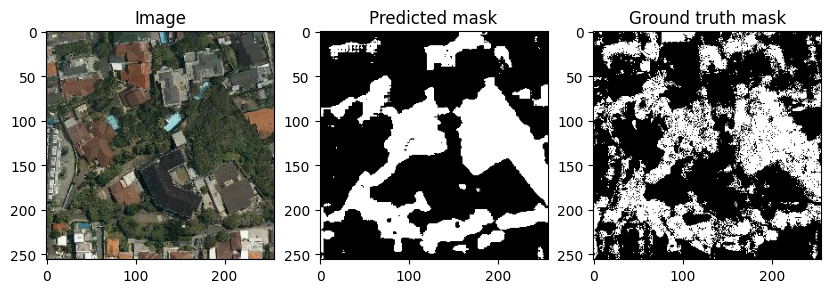

In [39]:
def ref_point(gt_mask):
    index = np.argwhere(gt_mask > 0)

    if len(index) > 0:
        if len(index) < 500:
            num_points = 5
        elif len(index) < 2000:
            num_points = 10
        elif len(index) < 10000:
            num_points = 15
        elif len(index) < 30000:
            num_points = 20
        elif len(index) < 50000:
            num_points = 25
        else:
            num_points = 30

        num_points = min(len(index), num_points)
        random_index = np.random.choice(len(index), num_points, replace = False)
        point = index[random_index]
        return point[:, ::-1].astype(np.float32)
    else:
        return np.array([[128, 128]], dtype = np.float32)

with rasterio.open(img_path) as src:
    img = src.read([1, 2, 3]) 
    img = np.transpose(img, (1, 2, 0))
        
gt_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

predictor_fine_tune.set_image(img)

point = ref_point(gt_mask)
label = np.ones(len(point), dtype = np.int32)  
point = np.array(point, dtype = np.float32)  

masks_fine_tune, scores, logits = predictor_fine_tune.predict(
    point_coords = point, point_labels = label, multimask_output = True  
)

best_mask_fine_tune = masks_fine_tune[np.argmax(masks_fine_tune.sum(axis = (1, 2)))]
best_mask_fine_tune = np.clip(best_mask_fine_tune, 0, 1)  
best_mask_fine_tune = (best_mask_fine_tune * 255).astype(np.uint8)

_, bin_mask_fine_tune = cv2.threshold(best_mask_fine_tune, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

plt.figure(figsize = (10, 10))
plt.subplot(1, 3, 1)
plt.imshow(img)
plt.title("Image")

plt.subplot(1, 3, 2)
plt.imshow(bin_mask_fine_tune, cmap = "gray")
plt.title("Predicted mask")

plt.subplot(1, 3, 3)
plt.imshow(gt_mask, cmap = "gray")
plt.title("Ground truth mask")

plt.show()

In [40]:
def calculate_iou(pred_mask, gt_mask):
    intersect = np.logical_and(gt_mask > 0, pred_mask > 0).sum()
    union = np.logical_or(gt_mask > 0, pred_mask > 0).sum()
    iou = intersect / union
    return iou

In [41]:
gt_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
iou_score = calculate_iou(bin_mask_fine_tune, gt_mask)
print(f"IoU score: {iou_score}")

IoU score: 0.5957387935805202


In [42]:
with rasterio.open(img_path) as src:
    image = src.read([1, 2, 3])  
    image = np.transpose(image, (1, 2, 0)) 
    resolution = src.res 

In [43]:
GSD_x, GSD_y = resolution
GSD = (GSD_x + GSD_y) / 2 
print(f"GSD: {GSD}")

GSD: 0.1


In [44]:
pixels = np.sum(bin_mask_fine_tune > 0)
print(f"Pixels: {pixels}")

Pixels: 22598


In [45]:
area = pixels * (GSD ** 2)
print(f"Vegetation coverage area: {area}")

Vegetation coverage area: 225.98000000000005


Multiple

In [46]:
predictor_fine_tune = SamPredictor(fine_tune_sam_model)

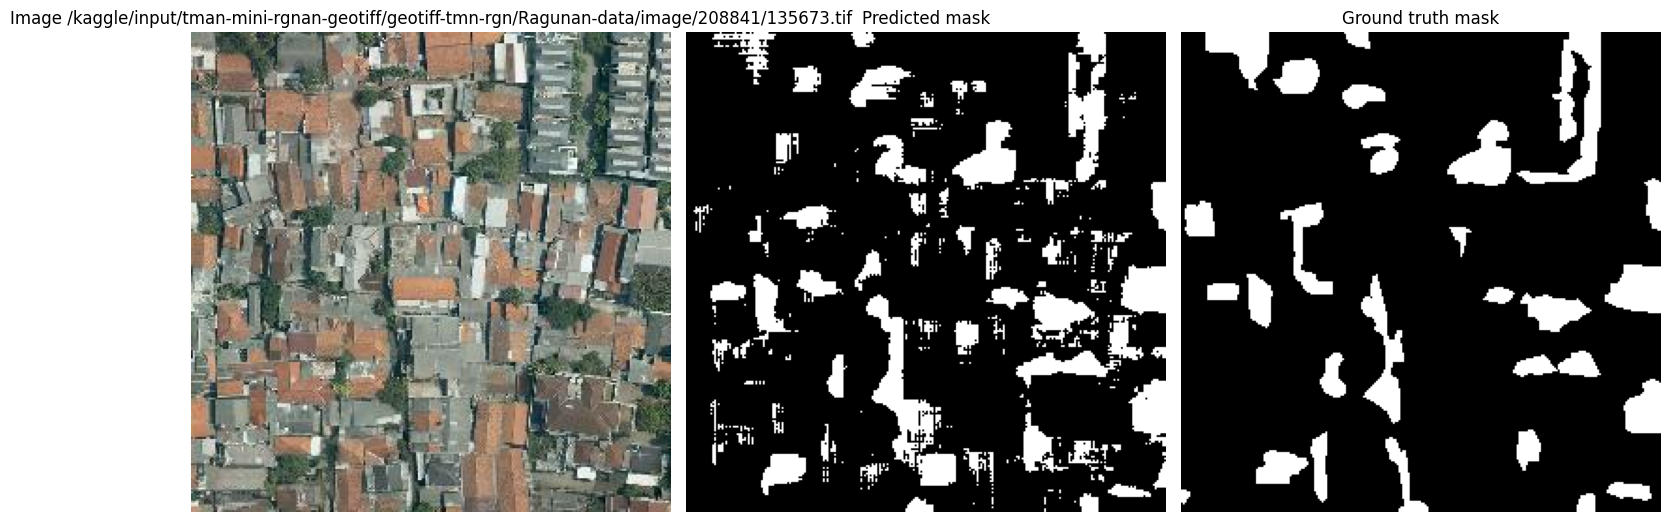

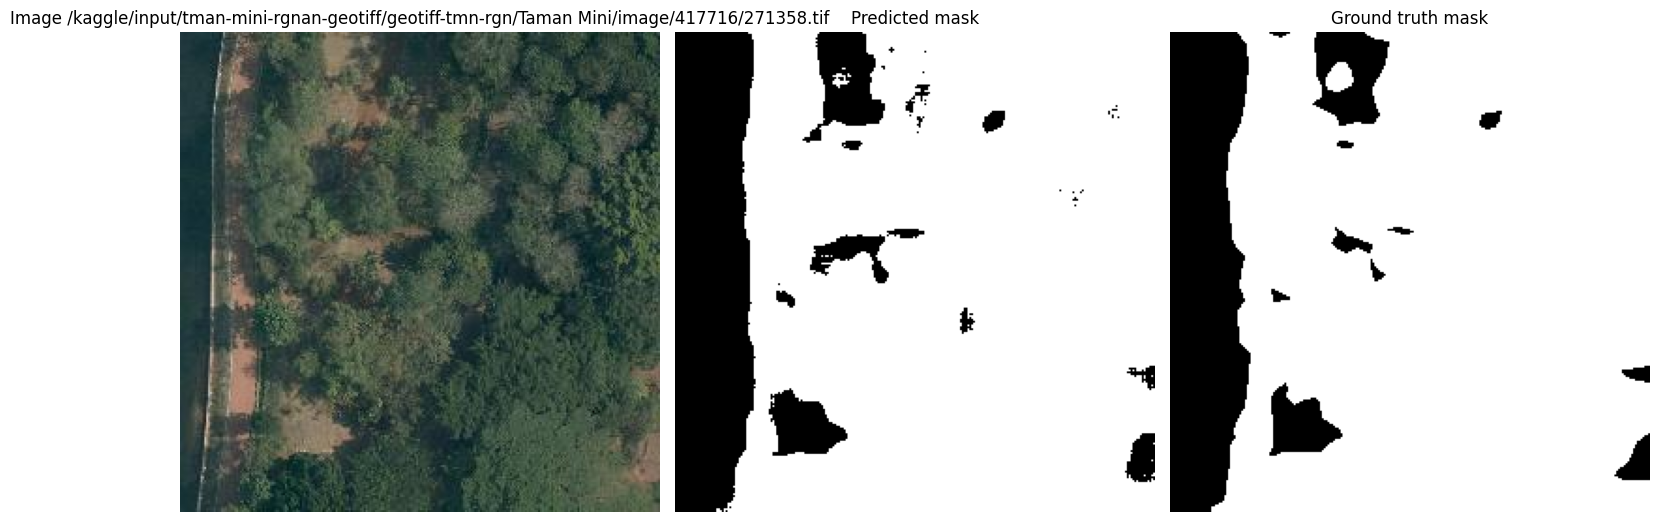

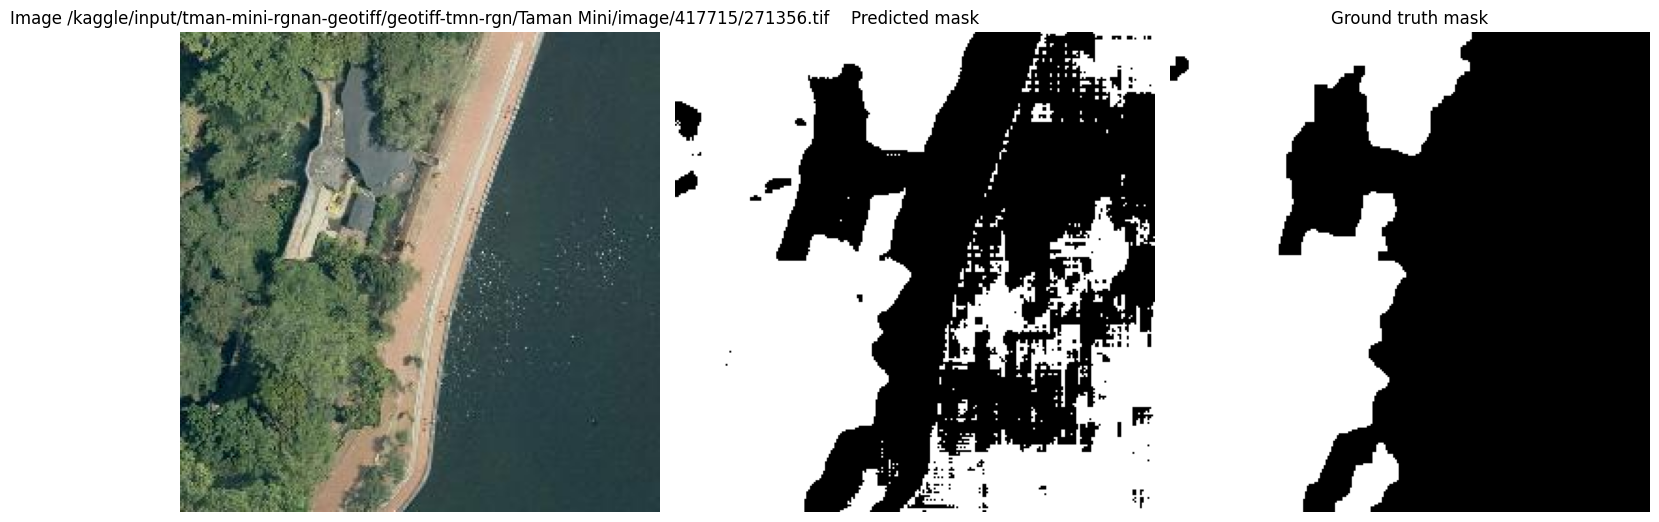

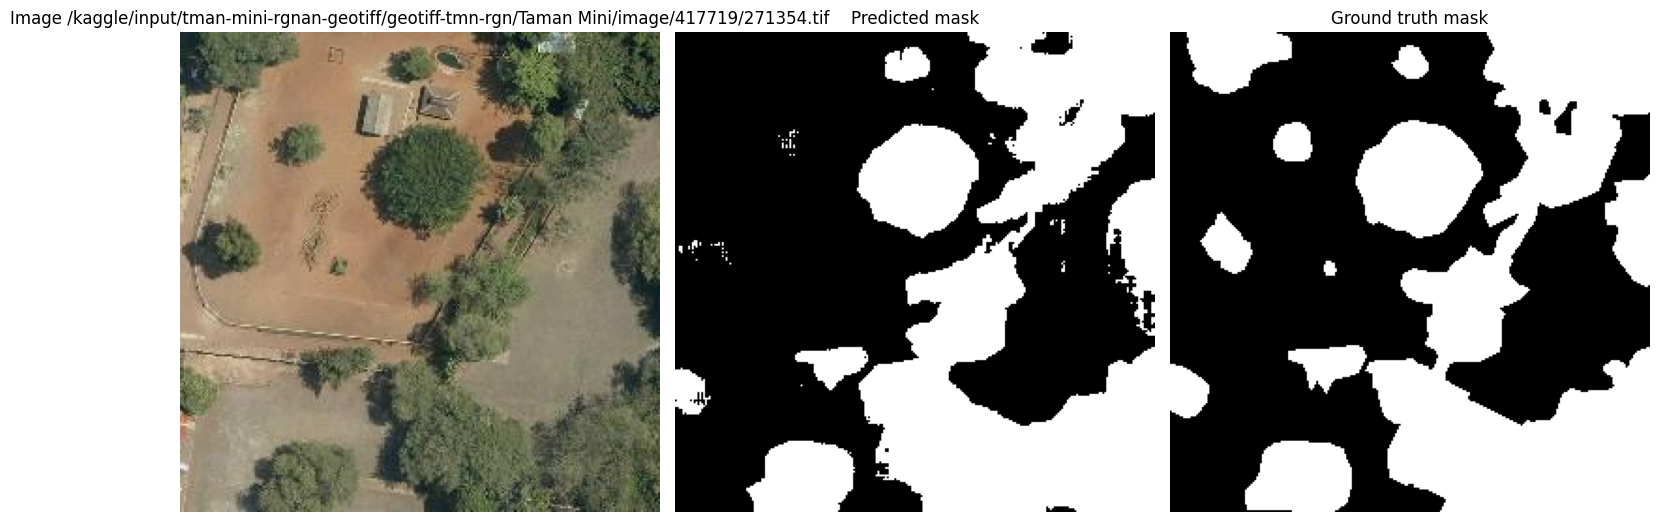

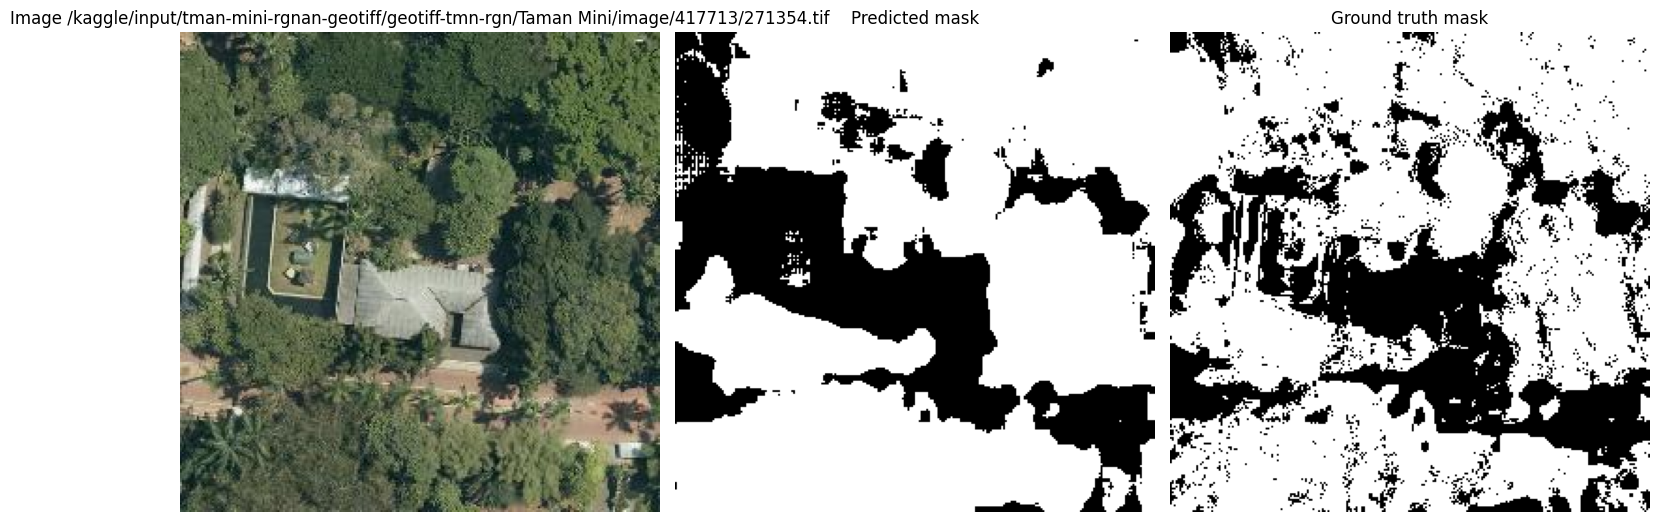

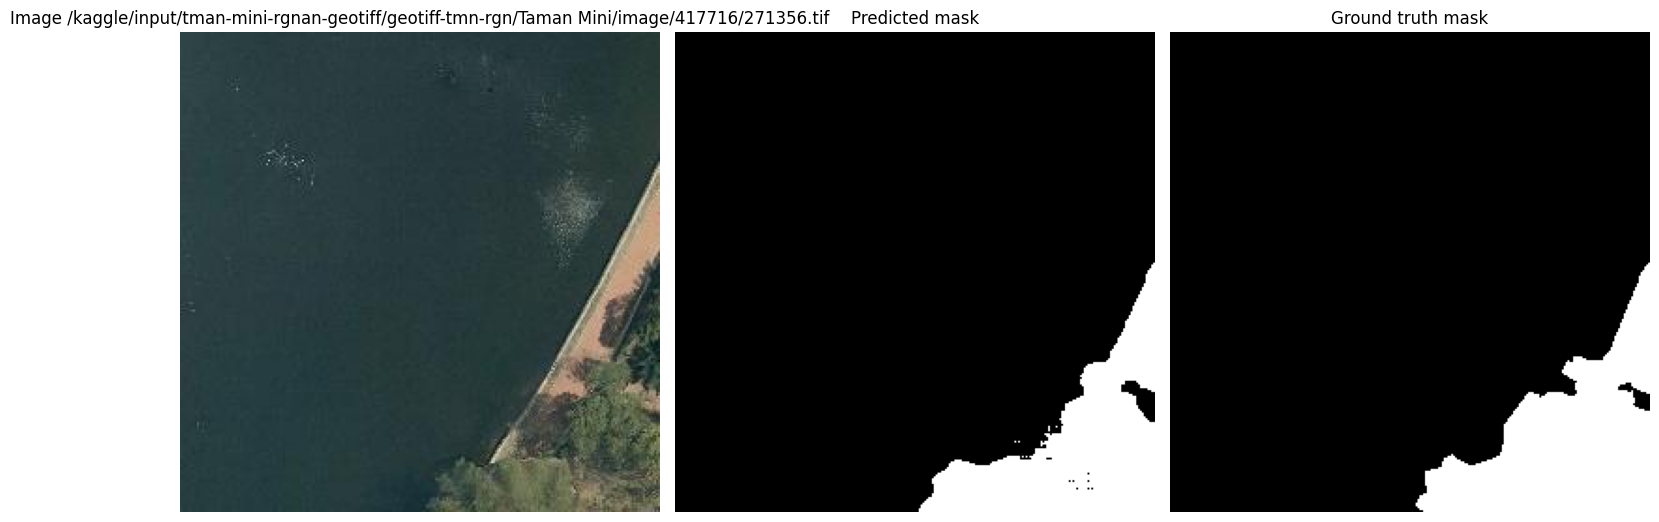

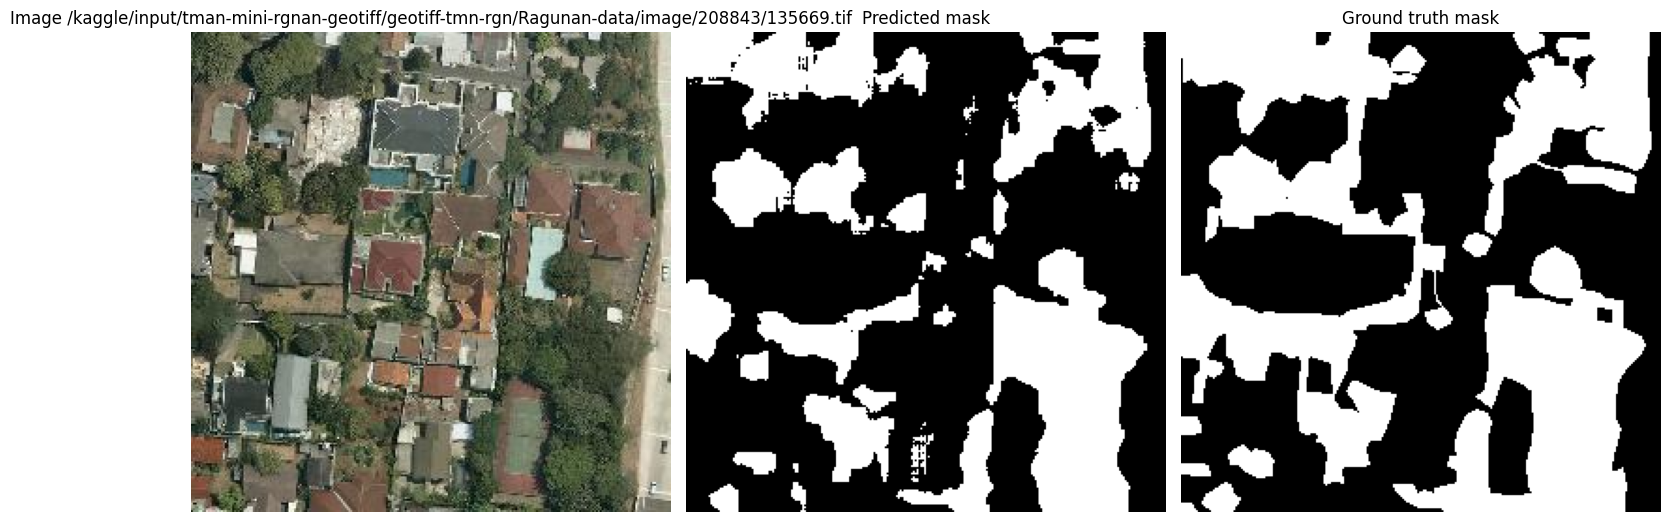

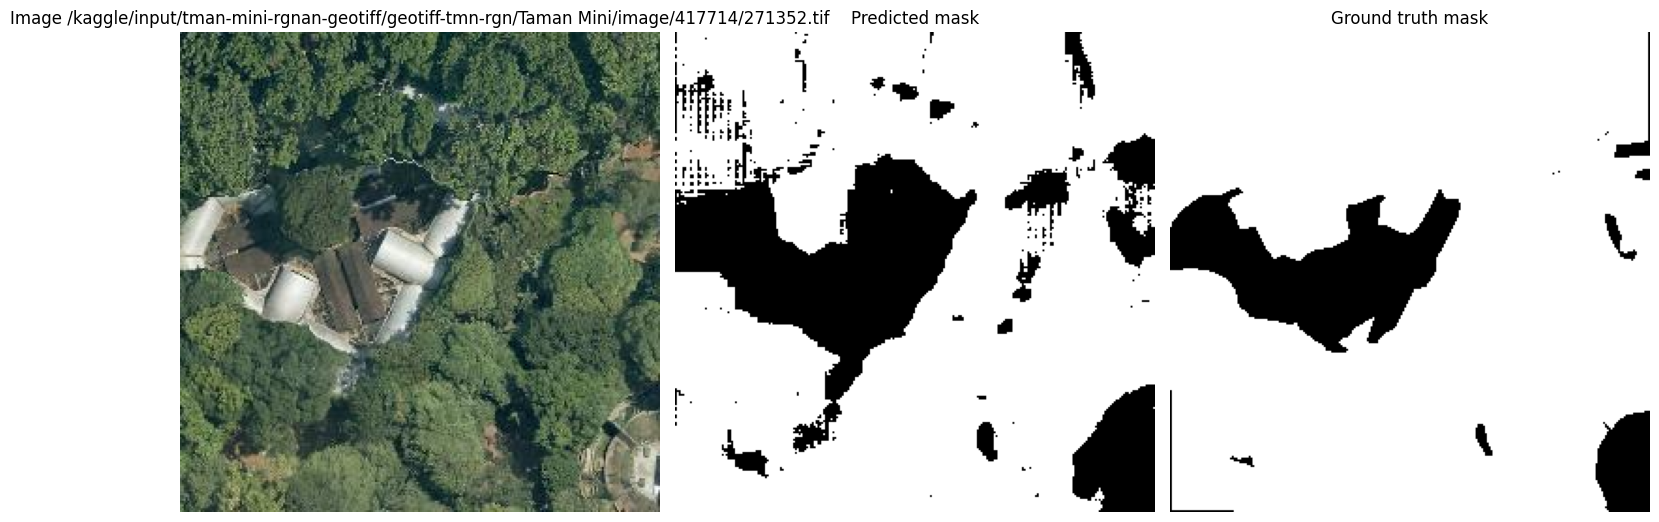

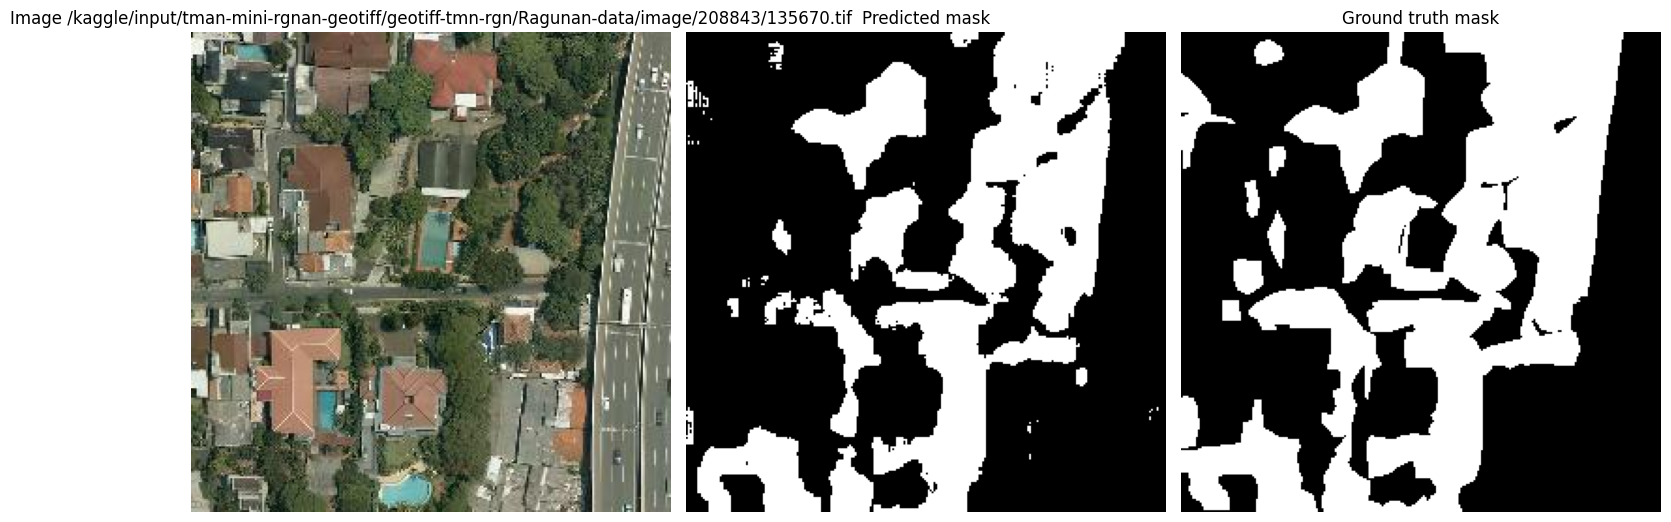

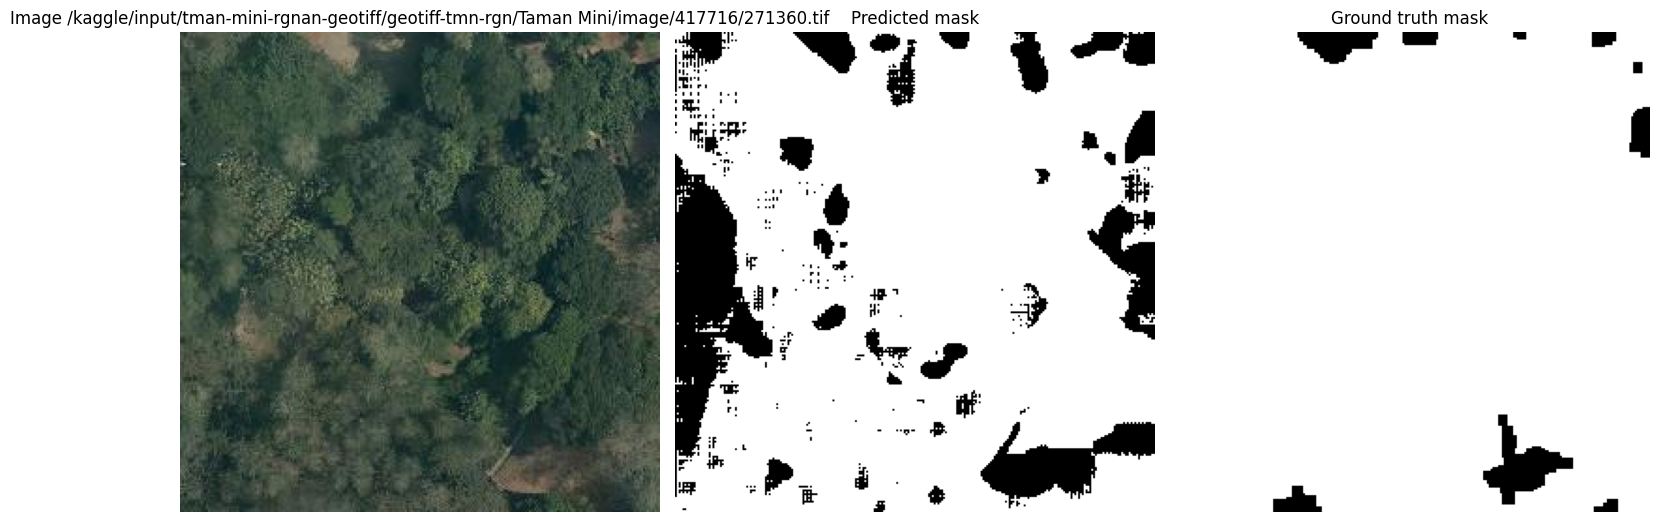

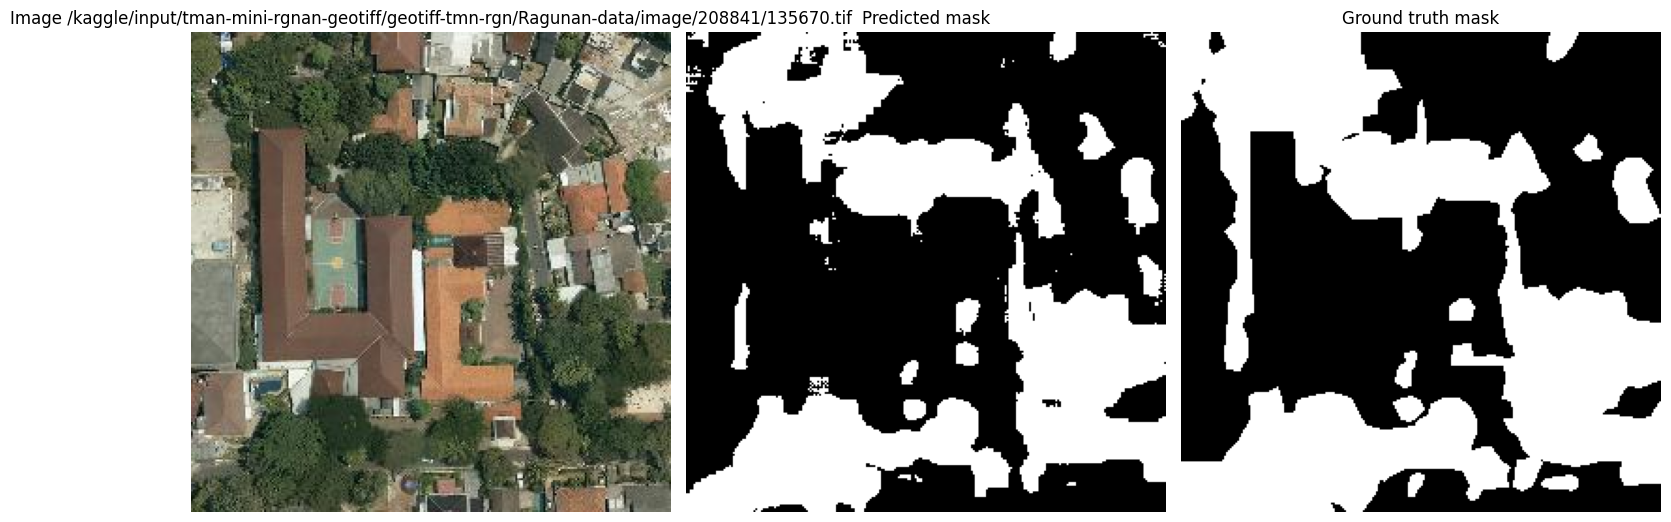

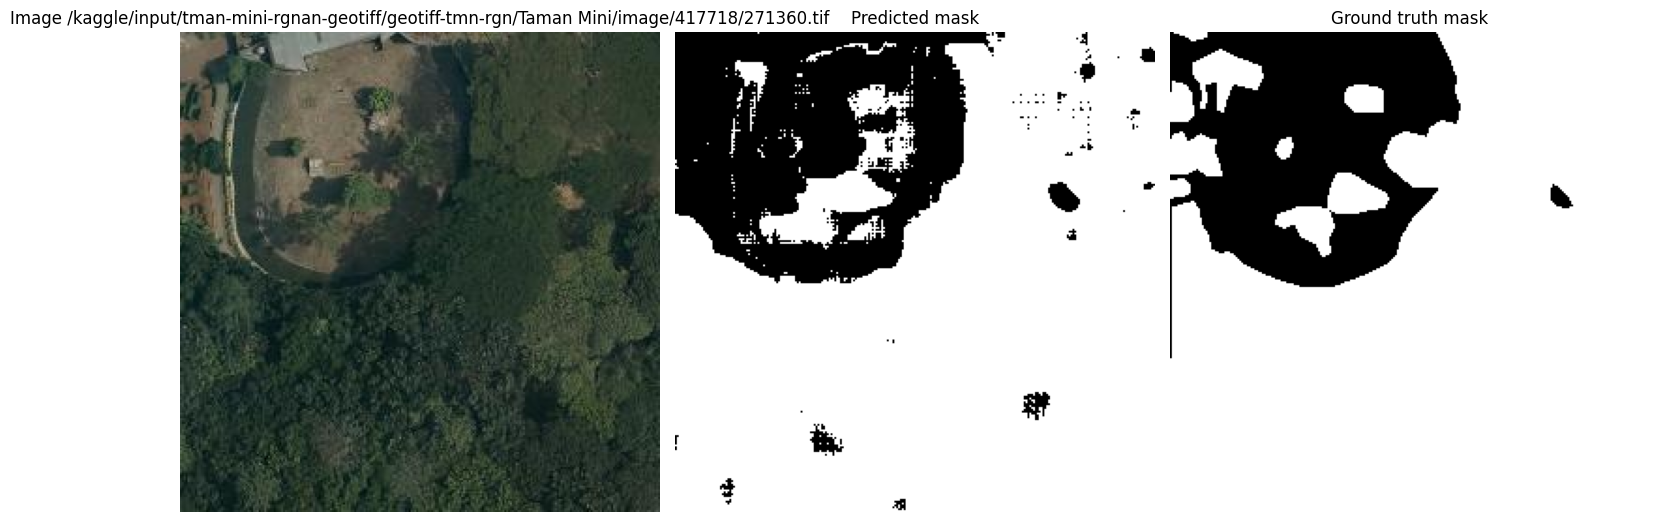

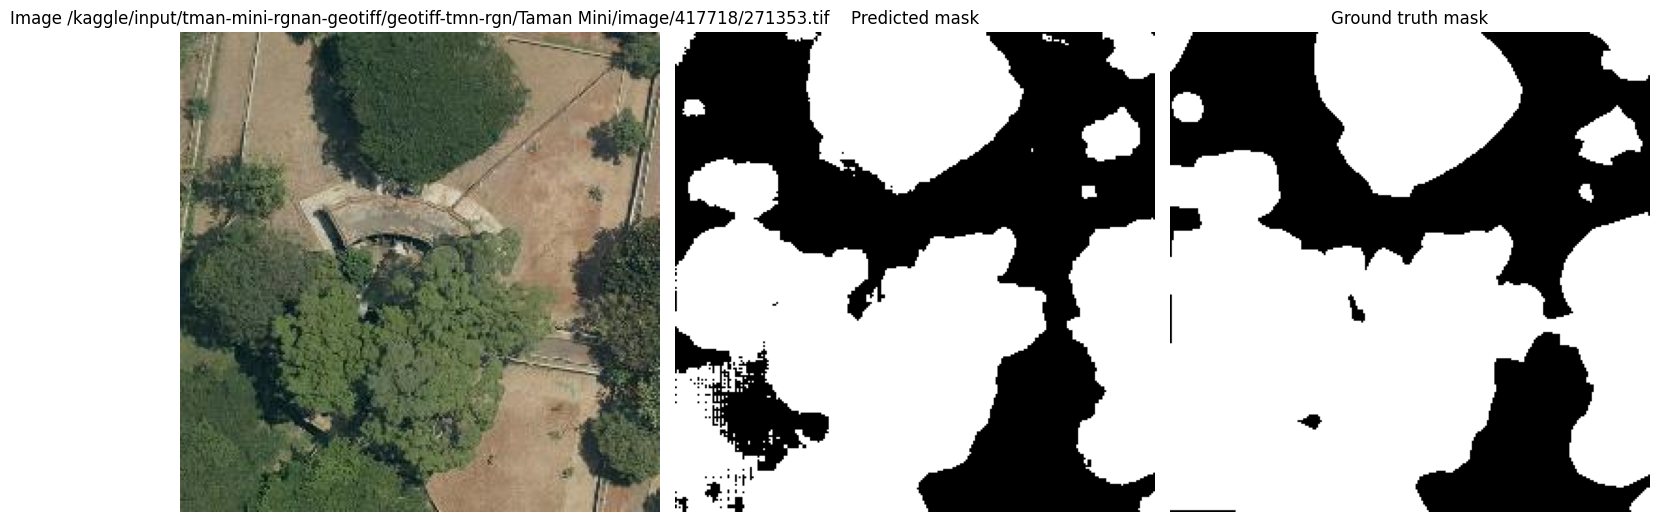

In [47]:
for image, mask, image_path, mask_path in test_loader:
    for i in range(len(image_path)): 
        with rasterio.open(image_path[i]) as src:
            img = src.read([1, 2, 3])
            img = np.transpose(img, (1, 2, 0)) 

        gt_mask = cv2.imread(mask_path[i], cv2.IMREAD_GRAYSCALE)

        predictor_fine_tune.set_image(img)

        point = ref_point(gt_mask) 
        if len(point) == 0:
            print(f"No ref points in {mask_path[i]}")
            continue
            
        label = np.ones(len(point), dtype = np.int32)

        masks_fine_tune, scores, logits = predictor_fine_tune.predict(
            point_coords = point, point_labels = label, multimask_output = True
        )

        best_mask = masks_fine_tune[np.argmax(masks_fine_tune.sum(axis = (1, 2)))]
        best_mask = np.clip(best_mask, 0, 1)
        best_mask = (best_mask * 255).astype(np.uint8)

        _, bin_mask = cv2.threshold(best_mask, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        plt.figure(figsize = (15, 8))
        plt.subplot(1, 3, 1)
        plt.imshow(img)
        plt.title(f"Image {image_path[i]}")
        plt.axis("off")
    
        plt.subplot(1, 3, 2)
        plt.imshow(bin_mask, cmap = "gray")
        plt.title("Predicted mask")
        plt.axis("off")
    
        plt.subplot(1, 3, 3)
        plt.imshow(gt_mask, cmap = "gray")
        plt.title("Ground truth mask")
        plt.axis("off")
    
        plt.tight_layout()
        plt.show()

In [48]:
for image, mask, image_path, mask_path in test_loader:
    for i in range(len(image_path)): 
        with rasterio.open(image_path[i]) as src:
            img = src.read([1, 2, 3])
            img = np.transpose(img, (1, 2, 0)) 
            GSD_x, GSD_y = src.res
            GSD = (GSD_x + GSD_y) / 2

        gt_mask = cv2.imread(mask_path[i], cv2.IMREAD_GRAYSCALE)

        predictor_fine_tune.set_image(img)

        point = ref_point(gt_mask)
        if len(point) == 0:
            print(f"No ref points in {mask_path[i]}")
            continue
        label = np.ones(len(point), dtype = np.int32)

        masks_fine_tune, scores, logits = predictor_fine_tune.predict(
            point_coords = point, point_labels = label, multimask_output = True
        )

        best_mask = masks_fine_tune[np.argmax(masks_fine_tune.sum(axis = (1, 2)))]
        best_mask = np.clip(best_mask, 0, 1)
        best_mask = (best_mask * 255).astype(np.uint8)

        _, bin_mask = cv2.threshold(best_mask, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        pixels = np.sum(bin_mask > 0)
        veg_area = pixels * (GSD ** 2)

        iou = calculate_iou(bin_mask, gt_mask)
        
        print(f"Image {image_path[i]}")
        print(f"GSD: {GSD}")
        print(f"Pixels: {pixels}")
        print(f"Vegetation coverage area: {veg_area}")
        print(f"IoU score: {iou}")
        print("=========================")

Image /kaggle/input/tman-mini-rgnan-geotiff/geotiff-tmn-rgn/Ragunan-data/image/208841/135673.tif
GSD: 0.1
Pixels: 19724
Vegetation coverage area: 197.24000000000004
IoU score: 0.32522113754067555
Image /kaggle/input/tman-mini-rgnan-geotiff/geotiff-tmn-rgn/Taman Mini/image/417716/271358.tif
GSD: 0.1
Pixels: 51410
Vegetation coverage area: 514.1000000000001
IoU score: 0.9499813780260707
Image /kaggle/input/tman-mini-rgnan-geotiff/geotiff-tmn-rgn/Taman Mini/image/417715/271356.tif
GSD: 0.1
Pixels: 39772
Vegetation coverage area: 397.7200000000001
IoU score: 0.6142491920312575
Image /kaggle/input/tman-mini-rgnan-geotiff/geotiff-tmn-rgn/Taman Mini/image/417719/271354.tif
GSD: 0.1
Pixels: 28039
Vegetation coverage area: 280.39000000000004
IoU score: 0.83391289948667
Image /kaggle/input/tman-mini-rgnan-geotiff/geotiff-tmn-rgn/Taman Mini/image/417713/271354.tif
GSD: 0.1
Pixels: 45773
Vegetation coverage area: 457.7300000000001
IoU score: 0.760608299949438
Image /kaggle/input/tman-mini-rgnan-ge